In [1]:
import pandas as pd

这个数据集是台湾某银行 2005 年 4 月到 9 月的信用卡数据，数据集一共包括 25 个字段。
现在我们的目标是要针对这个数据集构建一个分析信用卡违约率的分类器。
具体选择哪个分类器，以及分类器的参数如何优化，我们可以用 GridSearchCV 这个工具跑一遍。

项目描述：

信用卡违约率分析：针对台湾某银行信用卡的数据，构建一个分析信用卡违约率的分类器。
采用 Random Forest 算法，信用卡违约率识别率在 80% 左右。

In [56]:
# 调包
import pandas as pd
from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
# 分类器库
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
# 可视化库
from matplotlib import pyplot as plt
import seaborn as sns

In [57]:
# 数据加载
data = pd.read_csv('./UCI_Credit_Card.csv')

(30000, 25)
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2      

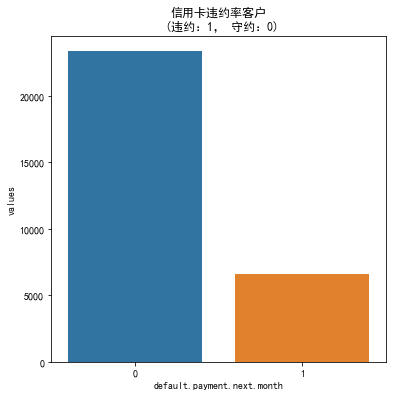

In [58]:
# 数据探索
# (30000, 25)
print(data.shape)
print(data.columns)
print(data.info())
print(data.describe())
print(data['SEX'].value_counts())
# 查看下一个月违约率的情况
print(data['default.payment.next.month'].value_counts())
# 查看下一个月违约率的情况
next_month = data['default.payment.next.month'].value_counts()
df = pd.DataFrame(
    {'default.payment.next.month' : next_month.index,
     'values' : next_month.values}
)
# 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(6, 6))
plt.title('信用卡违约率客户\n (违约：1， 守约：0)')
sns.set_color_codes('pastel')
sns.barplot(x = 'default.payment.next.month', y = 'values', data = df)
locs, labels = plt.xticks()
plt.show()

In [59]:
# 特征选择
# 特征选择，去掉 ID 字段、最后一个结果字段即可
# ID 这个字段没有用
data.drop(['ID'], inplace = True, axis = 1)
target = data['default.payment.next.month']
columns = data.columns.tolist()
columns.remove('default.payment.next.month')
features = data[columns]

In [60]:
# 划分训练集、测试集:30%作为测试集，其余作为训练集
train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.3, stratify = target, random_state=1)

In [64]:
# 构造分类器：分类器函数、名称、参数字典
# 1、构造各种分类器
clasifiers = [
    # kernel 代表核函数的选择，它有四种选择，只不过默认是 rbf，即高斯核函数。
    SVC(random_state=1, kernel='rbf'),
    # 默认情况下 criterion 这个参数等于 gini，也就是按照基尼系数来选择属性划分，即默认采用的是 CART 分类树。
    DecisionTreeClassifier(random_state=1, criterion='gini'),
    # 决策树的分类标准，默认是基尼指数（CART算法）。
    RandomForestClassifier(random_state=1, criterion='gini'),
    # metric：指定距离度量方法，一般都是使用欧式距离。'minkowski’： 闵可夫斯基距离，默认参数。
    KNeighborsClassifier(metric = 'minkowski'),
    AdaBoostClassifier(random_state=1)
]
# 2、分类器名称
clasifier_names = [
    'svc',
    'decisiontreeclassifier',
    'randomforestclassifier',
    'kneiborsclassifier',
    'adaboostclassifier'
]
# 3、分类器参数
classifier_param_grid = [
    # 参数 C 代表目标函数的惩罚系数，惩罚系数指的是分错样本时的惩罚程度，默认情况下为 1.0。
    # 当 C 越大的时候，分类器的准确性越高，但同样容错率会越低，泛化能力会变差。相反，C 越小，泛化能力越强，但是准确性会降低。
    # 参数 gamma 代表核函数的系数，默认为样本特征数的倒数，即 gamma = 1 / n_features
    {'svc__C':[1], 'svc__gamma':[0.01]},
    {'decisiontreeclassifier__max_depth':[6, 9, 11]},
    # 随机森林决策树的个数，默认是10
    {'randomforestclassifier__n_estimators':[3, 5, 6]},
    # n_neighbors：即 KNN 中的 K 值，代表的是邻居的数量。
    # K 值如果比较小，会造成过拟合。如果 K 值比较大，无法将未知物体分类出来。一般我们使用默认值 5。
    {'kneiborsclassifier__n_neighbors':[4, 6, 8]},
    {'adaboostclassifier__n_estimators':[10, 50, 100]}
]

In [65]:
# 构造GridSearchCV参数调优函数
def GridSearchCV_work(pipeline, train_x, train_y, test_x, text_y, param_grid, score = 'accuracy'):
    response = {}
    gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = score)
    # 寻找最优的参数 和 最优的准确率分数
    # 使用21000条数据去训练模型
    search = gridsearch.fit(train_x, train_y)
    print("GridSearch 最优参数： ", search.best_params_)
    print("GridSearch 最优分数： %0.4lf" %search.best_score_)
    # 对剩下的9000条数据进行预测
    prdict_y = gridsearch.predict(test_x)
    # 计算准确率，正确数据在前、预测数据在后
    print("准确率为： %0.4lf" %accuracy_score(test_y, prdict_y))
    response['predict_y'] = prdict_y
    response['accuracy_score'] = accuracy_score(test_y, prdict_y)
    # 打印返回字典，包含预测结果、准确率
    # print(response)
    return response

In [66]:
# 以下是主程序：
    # 1、先输入了SVC，

# 循环输出分类器参数、分数
for model, model_name, model_param_grid in zip(clasifiers, clasifier_names, classifier_param_grid):
    # 依次传入不同的模型、模型姓名、模型参数网格，形成不同的pipeline，最终输入到GridSearchCV，去输出最优的参数、分数、预测率
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (model_name, model)
    ])
    result = GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid, score = 'accuracy')

GridSearch 最优参数：  {'svc__C': 1, 'svc__gamma': 0.01}
GridSearch 最优分数： 0.8186
准确率为： 0.8172
GridSearch 最优参数：  {'decisiontreeclassifier__max_depth': 6}
GridSearch 最优分数： 0.8208
准确率为： 0.8113
GridSearch 最优参数：  {'randomforestclassifier__n_estimators': 60}
GridSearch 最优分数： 0.8154
准确率为： 0.8137
GridSearch 最优参数：  {'kneiborsclassifier__n_neighbors': 8}
GridSearch 最优分数： 0.8039
准确率为： 0.8036
GridSearch 最优参数：  {'adaboostclassifier__n_estimators': 10}
GridSearch 最优分数： 0.8188
准确率为： 0.8129
